### Getting that juicy clubhouse data

In [34]:
import pandas as pd
import sqlite3
conn = sqlite3.connect("Clubhouse_Dataset_v1.db") # kaggle.com/johntukey/clubhouse-dataset/download
club_df = pd.read_sql_query("SELECT * FROM user", conn)
club_twitt = pd.unique(list(club_df['twitter']))

### Importing your twitter followers (if you have some!)

In [32]:
# get your tokens here: https://developer.twitter.com/en
# otherwise just skip this step and fill 'followers' manually
import tweepy
consumer_key = None
consumer_secret = None
access_token = None
access_token_secret = None
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [53]:
# import time
# import pickle
# sleeptime = 4
# pages = tweepy.Cursor(api.followers, screen_name="MichaelTrazzi").pages()
# users = []
# with open('followers.txt', 'w') as f:
#     while True:
#         try:
#             page = next(pages)
#             time.sleep(sleeptime)
#         except tweepy.RateLimitError: #taking extra care of the "rate limit exceeded"
#             time.sleep(60*15) # API limits us to 80 requests every 15 minutes :(
#             page = next(pages)
#         except StopIteration:
#             break
#         for user in page:
#             print(f'{len(users)}: {user.screen_name}')
#             users.append(user)
#             pickle.dump(users, open('users.p', 'wb'))
#             print(user.id_str, file=f) # logging to not lose everything

In [54]:
# change with 'followers = ['awesome_follower_1', ...] if you skipped the previous step'
followers = [us.screen_name for us in users]

### Merging the twitter and clubhouse data into some, hum, hype followers dictionary?

In [65]:
hype_followers = [tw_name for tw_name in club_twitt if tw_name in followers]
hype_foll_dic = {tw_name: users[followers.index(tw_name)] for tw_name in hype_followers}

In [268]:
import os
import requests

for website in ['ch', 'tw']:
    os.makedirs(f'./{website}_imgs/', exist_ok=True)
hype_dic = {}
for m8 in hype_followers:
    ch_user = club_df.loc[list(club_df['twitter']).index(m8)]
    hype_dic[m8] = {'ch': ch_user.num_followers,
                    'tw': hype_foll_dic[m8].followers_count}
    ch_url, tw_url = ch_user['photo_url'], hype_foll_dic[m8].profile_image_url
#     for (website, url) in zip(['ch', 'tw'], [ch_url, tw_url]):
#         if url is not None:
#             url = url.replace('_normal', '') # handles small twitter images
#             with open(f'./{website}_imgs/{m8}.png', 'wb') as f:
#                 pic = requests.get(url).content
#                 f.write(pic)
#                 hype_dic[m8]['pic'] = pic

In [271]:
# run on your terminal the line below to compare twitter vs. clubhouse
# for name in $(ls ch_imgs); do open ch_imgs/$name tw_imgs/$name; done
diff_pics = ['michellehuang42', 'rainieratx', 'malharjere', 'aashiq', '_afsheen_a', 'TetraspaceWest', 'InquilineKea',
             'GrantTBurke', 'AlexnBriand', 'snigdhar0y']
for name in hype_dic:
    hype_dic[name]['changed'] = (name in diff_pics)

[]

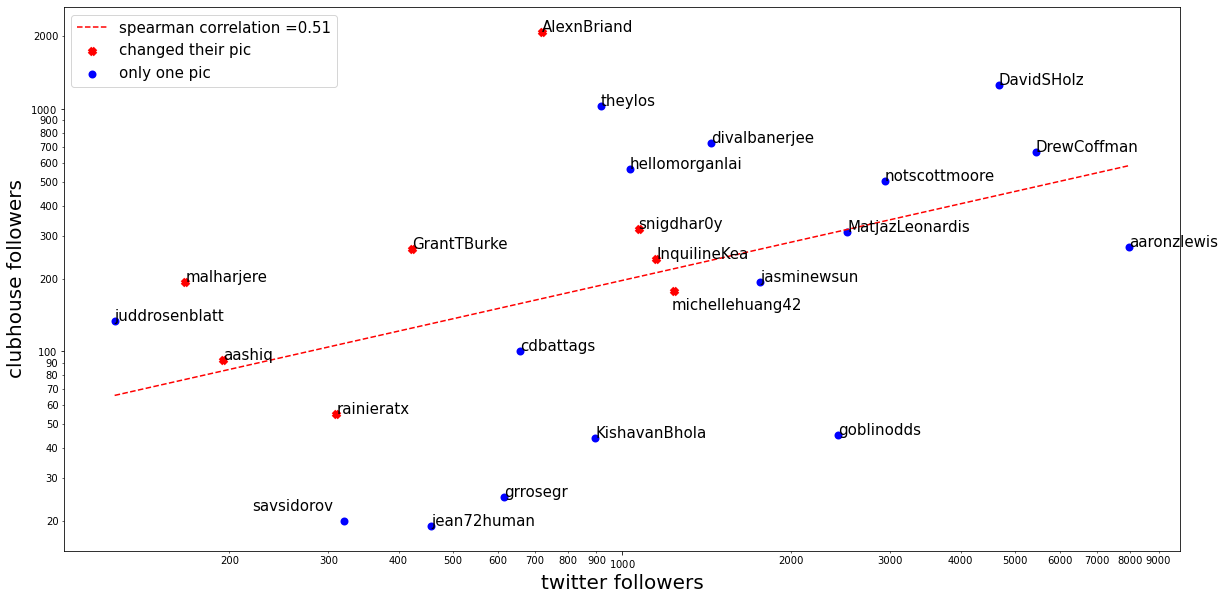

In [298]:
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(20, 10))
hype_dic = {k: v for k, v in sorted(hype_dic.items(), key=lambda item: item[1]['ch'])
                                    if v['tw'] >= 100 and v['ch'] >= 10}
tw, ch = [[nb_follows[website] for nb_follows in hype_dic.values()]
                  for website in ['tw', 'ch']]
tw_log, ch_log = list(map(np.log10, [tw, ch]))

names = list(hype_dic.keys())
def has_changed(idx): return hype_dic[names[idx]]['changed']

tw_chg, ch_chg = [[pt for (i, pt) in enumerate(pt_l) if has_changed(i)] for pt_l in [tw, ch]]
tw_nochg, ch_nochg = [[pt for (i, pt) in enumerate(pt_l) if not has_changed(i)] for pt_l in [tw, ch]]

ax.scatter(tw_chg, ch_chg, c='r', marker='x', linewidths=5, label='changed their pic')
ax.scatter(tw_nochg, ch_nochg, c='b', marker='.', linewidths=5, label='only one pic')

# straight line
m, b = np.polyfit(tw_log, ch_log, 1)
x = np.linspace(min(tw_log), max(tw_log), 100)
plt.plot(np.exp(x * np.log(10)), np.exp((m * x + b) * np.log(10)), 'r--',
         label=f'spearman correlation ={stats.spearmanr(tw_log, ch_log)[0]:.2f}')


# annotation
offset = {name: (0, 0) for name in hype_dic}
offset['savsidorov'] = (-100, 2)
offset['michellehuang42'] = (-10, -30)

for (name, nbs) in hype_dic.items():
    x, y = nbs['tw'], nbs['ch']
    off = offset[name]
    ax.annotate(name, (x, y), xytext=(x + off[0], y + off[1]), fontsize=15)
    
# axis

ax.set_xscale('log')
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', which='minor')
ax.set_xlabel('twitter followers', fontsize=20)
ax.set_ylabel('clubhouse followers', fontsize=20)
ax.xaxis.set_minor_formatter(mtick.FormatStrFormatter("%.0d"))
ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter("%.0d"))
ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))

plt.legend(fontsize=15)
plt.plot()